# STEPS:

1. Normalization and reshaping image data
2. One Hot Encoding Labels
3. Splitting into train/test sets
4. Image Augmentation using ImageDataGenerator *
5. Custom Callback/LR Scheduling and choosing Optimizer
6. Making Model Architecture and compile model
7. Fit data into DataGenerator object
8. Plot Accuracy, Losses 

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPool2D,Dropout,LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ahdd1/csvTrainImages 60k x 784.csv
/kaggle/input/ahdd1/csvTestLabel 10k x 1.csv
/kaggle/input/ahdd1/csvTrainLabel 60k x 1.csv
/kaggle/input/ahdd1/Train + Test Matlab.mat
/kaggle/input/ahdd1/csvTestImages 10k x 784.csv
/kaggle/input/ahdd1/csvTrainImages 60k x 784/csvTrainImages 60k x 784.csv
/kaggle/input/ahdd1/Arabic Handwritten Digits Dataset CSV/csvTrainImages 60k x 784.csv
/kaggle/input/ahdd1/Arabic Handwritten Digits Dataset CSV/csvTestLabel 10k x 1.csv
/kaggle/input/ahdd1/Arabic Handwritten Digits Dataset CSV/csvTrainLabel 60k x 1.csv
/kaggle/input/ahdd1/Arabic Handwritten Digits Dataset CSV/csvTestImages 10k x 784.csv


In [3]:
X_train = pd.read_csv('/kaggle/input/ahdd1/csvTrainImages 60k x 784.csv')
y_train = pd.read_csv('/kaggle/input/ahdd1/Arabic Handwritten Digits Dataset CSV/csvTrainLabel 60k x 1.csv')
X_test = pd.read_csv('/kaggle/input/ahdd1/csvTestImages 10k x 784.csv')
y_test = pd.read_csv('/kaggle/input/ahdd1/Arabic Handwritten Digits Dataset CSV/csvTestLabel 10k x 1.csv')
print('X_train : ',X_train.shape,', y_train', y_train.shape)
print('X_test  : ',X_test.shape,' , y_test ', y_test.shape)

X_train :  (59999, 784) , y_train (59999, 1)
X_test  :  (9999, 784)  , y_test  (9999, 1)


In [4]:
# Normalise and reshape
X_train=X_train.values.reshape((-1,28,28,1))/255.0
X_test=X_test.values.reshape((-1,28,28,1))/255.0

In [5]:
# OnehotEncode y_train
y_train=to_categorical(y_train, num_classes=10)
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [6]:
# Split into Train and validation
X_train,X_valid,y_train, y_valid = train_test_split(X_train, y_train,
                                                     test_size=0.1,
                                                     shuffle=True)
# Data Augmentation to reduce bias
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [7]:
# Early Stopping
class custom_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.92):
            self.model.stop_training=True
            
# LR Scheduler
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [8]:
# MODEL
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same',
                activation='relu', input_shape=(28,28,1)))
    model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same',
                activation='relu', input_shape=(28,28,1)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same',
                activation='relu', input_shape=(28,28,1)))
    model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same',
                activation='relu', input_shape=(28,28,1)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout((0.4)))
    model.add(Dense(10,activation='softmax'))
    return model

In [9]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model = build_model()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [10]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [11]:
epochs=10
batch_size=64
# Fit the model
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_valid,y_valid),
                              verbose = 2, callbacks=[learning_rate_reduction])

Epoch 1/10
844/844 - 20s - loss: 0.1726 - accuracy: 0.9464 - val_loss: 0.0482 - val_accuracy: 0.9863 - lr: 0.0010
Epoch 2/10
844/844 - 20s - loss: 0.0584 - accuracy: 0.9836 - val_loss: 0.0230 - val_accuracy: 0.9935 - lr: 0.0010
Epoch 3/10
844/844 - 20s - loss: 0.0464 - accuracy: 0.9872 - val_loss: 0.0165 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 4/10
844/844 - 20s - loss: 0.0465 - accuracy: 0.9874 - val_loss: 0.0245 - val_accuracy: 0.9928 - lr: 0.0010
Epoch 5/10
844/844 - 20s - loss: 0.0419 - accuracy: 0.9886 - val_loss: 0.0175 - val_accuracy: 0.9950 - lr: 0.0010
Epoch 6/10
844/844 - 20s - loss: 0.0446 - accuracy: 0.9885 - val_loss: 0.0321 - val_accuracy: 0.9925 - lr: 0.0010
Epoch 7/10
844/844 - 20s - loss: 0.0427 - accuracy: 0.9891 - val_loss: 0.0265 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 8/10
844/844 - 19s - loss: 0.0467 - accuracy: 0.9886 - val_loss: 0.0179 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 9/10
844/844 - 20s - loss: 0.0454 - accuracy: 0.9890 - val_loss: 0.0173 - val_accu

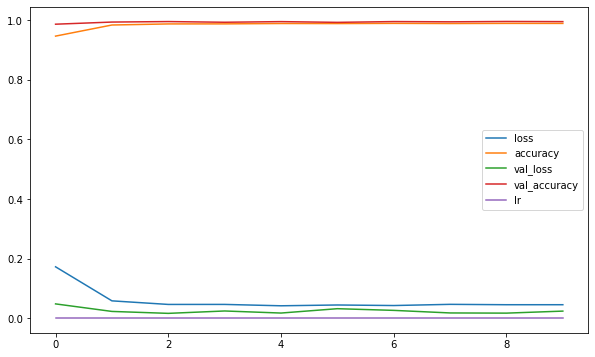

In [12]:
pd.DataFrame(history.history).plot(figsize=(10,6))

In [13]:
y_pred = model.predict(X_test)
y_test = to_categorical(y_test,num_classes=10)
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0390 - accuracy: 0.9927


[0.03899863362312317, 0.9926992654800415]

In [2]:
import pickle
filename = 'CNN_Model1.sav'
output_path='/output/kaggle/working/'
pickle.dump(model, open(output_path+filename, 'wb')) 
print('mission done!')

mission done!


In [18]:
model.save('/output/kaggle/working/CNN-model.model')